# Predicting Titanic Survivors

#### Matthew Fernandez

## Introduction
We will look at predicting whether or not an individual from the titanic wreck dataset survived or not. Using the machine learning algorithm, Decision Tree Classifier as our model. We will avoid overfitting by comparing our test accuracy mean with cross-validation, which is a great way to avoid overfitting. The titanic data tells us a lot about the individual's allocated on the Ship. Let's get to it.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns        
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

## Reading and preprocessing the data

### Read the data

The data set comes from https://www.kaggle.com/c/titanic/data. This data was accessed and obtained on April 24th, 2021.

In [3]:
input_file = "https://raw.githubusercontent.com/grbruns/cst383/master/titanic.csv"
df = pd.read_csv(input_file)

### Preprocessing

In [4]:
# column PassengerId
# a unique numeric passenger ID; not needed
df.drop('PassengerId', axis=1, inplace=True)

# column Cabin
# use only first letter of Cabin
df['Cabin'] = df['Cabin'].str.slice(stop=1)
df['Cabin'].fillna('U', inplace=True)

# column Ticket
# use two categories: tickets containing letters and
# tickets containing only digits
df['Ticket'] = df['Ticket'].str.contains('[a-zA-Z]')

# column Embarked
# hardly any NA embarked values, so drop rows containing them
df.dropna(subset=['Embarked'], inplace=True)

# column Name
# retain only the title of the name, if present
def extract_title(s):
    titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.']
    for title in titles:
        if title in s:
            return title
    return 'NoTitle'

df['Title'] = df['Name'].apply(extract_title)
df.drop('Name', axis=1, inplace=True)

# column Age
# fill with median value
df['Age'].fillna(df['Age'].median(), inplace=True)

# column Parch (number of parents and children)
# convert from object to numeric
df['Parch'] = df['Parch'].astype(int)

# column Pclass (1, 2, 3)
df['Pclass'] = df['Pclass'].astype(int)

# column Fare
df['Fare'] = df['Fare'].astype(float)

# confirm that no NA values remain
df.isna().mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Ticket    889 non-null    object 
 7   Fare      889 non-null    float64
 8   Cabin     889 non-null    object 
 9   Embarked  889 non-null    object 
 10  Title     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.3+ KB


## Initial data exploration

In [5]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.315152,0.524184,0.382452,32.096681
std,0.486260,0.834700,12.984932,1.103705,0.806761,49.697504
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


This classification of variables into categorical or numeric looks only at their types.

In [6]:
cat_vars = df.columns[df.dtypes == object].tolist()
print('Categorical variables: {}'.format(cat_vars))

num_vars = df.columns[df.dtypes != object].tolist()
print('Numeric variables: {}'.format(num_vars))

Categorical variables: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Title']
Numeric variables: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


#### Value counts for categorical variables

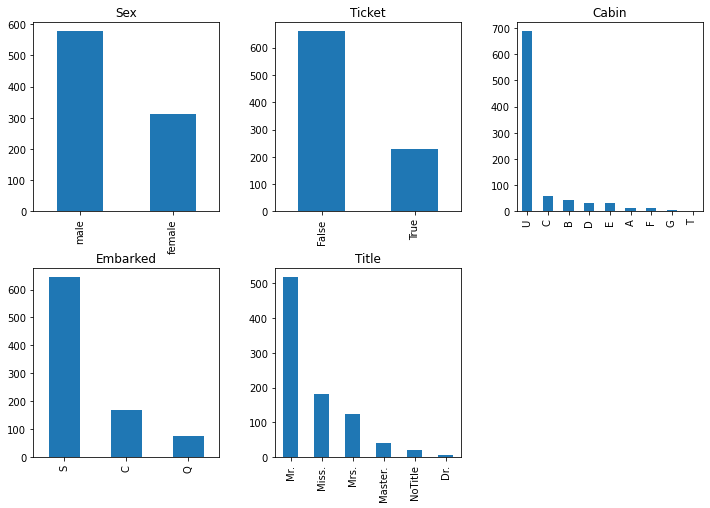

In [7]:
# from our textbook
# https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)   # adjust distance between plots
for i in range(1, len(cat_vars)+1):
    plt.subplot(2, 3, i)
    var = cat_vars[i-1]
    df[var].value_counts().plot.bar()
    plt.title(var);

#### Histograms for numeric variables

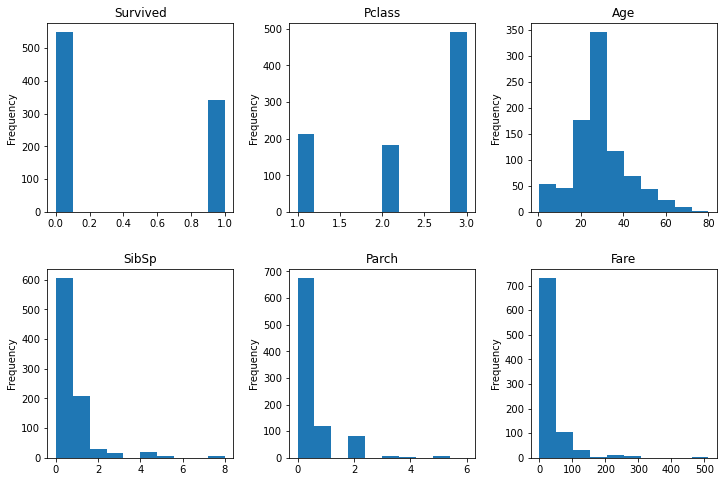

In [8]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(1, len(num_vars)+1):
    plt.subplot(2, 3, i)
    var = num_vars[i-1]
    df[var].plot.hist()
    plt.title(var);

From the histograms we can see that variables Survived and Pclass are categorical.  There are only three truly numeric variables in the data set: Age, SibSp, and Parch.  Furthermore, for SibSp and Parch, only a couple of values appear frequently.  It might be useful to convert SibSp and Parch into categorical variables.

## Data exploration

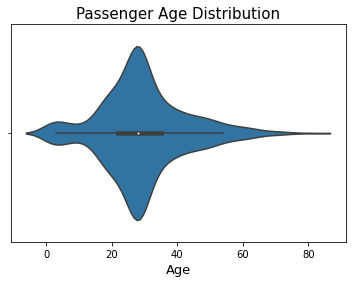

In [9]:
sns.violinplot(x='Age', data=df)
plt.title('Passenger Age Distribution', fontsize=15)
plt.xlabel('Age', fontsize=13);

We observe that the average age for a passanger was around 28 years of age.

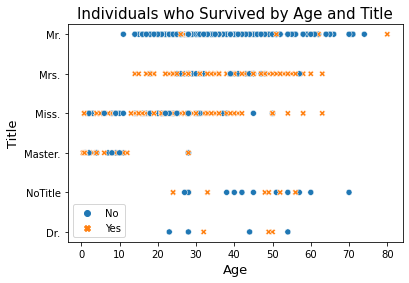

In [10]:
ax = sns.scatterplot(data=df, x='Age', y='Title', hue='Survived', style='Survived')
legend_labels, _ = ax.get_legend_handles_labels()
ax.legend(legend_labels, ['No', 'Yes'])
plt.xlabel('Age', fontsize=13)
plt.ylabel('Title', fontsize=13)
plt.title('Individuals who Survived by Age and Title', fontsize=15);

For this scatter plot, one can see that many of the survivors of the Titanic wreck were female, as indicated by the yellow X markers. There are a total of 340 individuals who survived the wreck, and 549 individuals who did not survive. Most women with the title 'Mrs.', survived. Note that only a select few fortunate individuals labeled 'Mr.' survived, otherwise those with the title Mr. were the least prioritized to survive. We will now look at the survival rate for each individuals title on a bar plot.

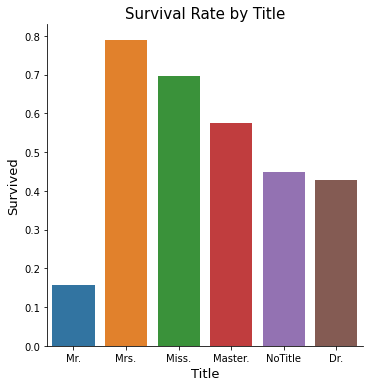

In [11]:
sns.catplot(x="Title", y='Survived', data =df, ci=None, kind='bar')
plt.title('Survival Rate by Title',fontsize=15)
plt.xlabel('Title',fontsize=13)
plt.ylabel('Survived',fontsize=13);

The categorical plot shown above depicts the survival rate per title from the titanic dataset. An individual with the title Mrs. has a 79% survival rate from all the women titled Mrs. in the dataset. Miss and Master's titles have the second and third highest survival rate, this is apparent because of the captain's explicit orders to save women and children first. Those with Mr. as a title abord the Titanic had less than 20% survival rate from all the Mr. combined, they're the least likely to survive the wreck.

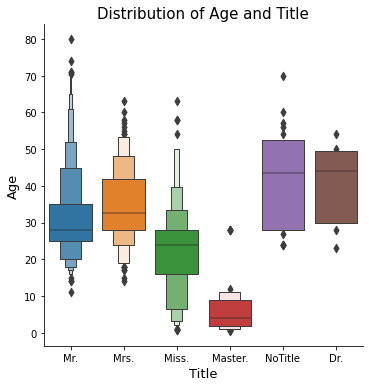

In [12]:
sns.catplot(y='Age', x='Title', kind='boxen' , data=df)
plt.title('Distribution of Age and Title',fontsize=15)
plt.ylabel('Age',fontsize=13)
plt.xlabel('Title',fontsize=13);

This boxed categorical plot represents the age per title, one can see the average ages per title are encapsulated in the largest box per title. The 'Master' title has an average age of 5 years, this makes sense since these individuals are too young to be titled as Mister. The 'Mr.' category has an average age of 28, the 'Mrs.' average age is about 33, the 'Miss.' average age is roughly 28, and the 'Dr.' title has an average of 45 years of age. 

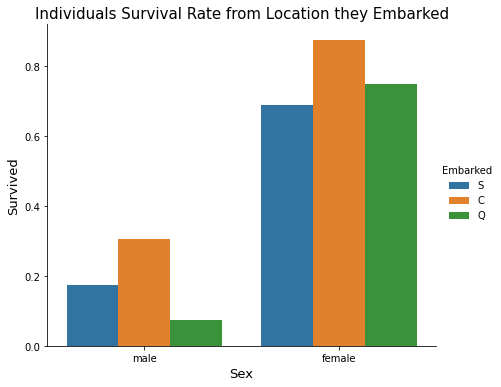

In [13]:
g = sns.catplot(x='Sex', y='Survived', hue='Embarked', kind='bar', ci=None, aspect=1.2, data=df)
plt.title('Individuals Survival Rate from Location they Embarked', fontsize =15)
plt.xlabel('Sex', fontsize =13)
plt.ylabel('Survived', fontsize =13);

From this plot, we can see that if an individual embarked on C(Cherbourg), they're most likely to survive from their respective sex category.

## Building a classification tree

This numpy random seed will be used for reproducibility of the model that follows.

In [14]:
np.random.seed(123)

We will examine a decision tree based off of age, Pclass, and Fare, which will have a max depth of 2. We will get a gini score that tells us the probability of a particular variable for each node on the decision tree.

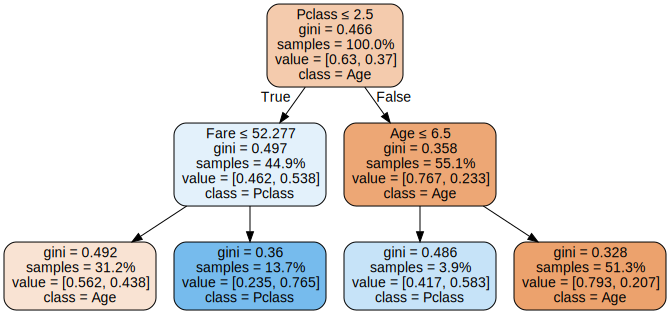

In [15]:
# source https://docs.google.com/document/d/1NV2GfldpKiKKiz3EwQJWawDXaDIDYY2SttcA2N80OZA/edit
from sklearn.tree import export_graphviz 
import graphviz # needed for the graph
predictors = ['Age', 'Pclass', 'Fare'] # features to predict from
# we must pass np arrays into our decision tree
X = df[predictors].values  # numpy array for predictor variables
y = df['Survived'].values  # numpy array for target variable
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state=0)
clf = DecisionTreeClassifier(max_depth=2, random_state=0).fit(X_train, y_train) 
# Using Decision Tree classifier model, and fit the model with the training data

dot_data = export_graphviz(clf, precision=3, 
                    feature_names=predictors,  
                 	proportion=True,
                 	class_names=predictors,  
                 	filled=True, rounded=True,  
                 	special_characters=True)
# plot it
graph = graphviz.Source(dot_data)  
graph

Following the decision tree to the leaf nodes, one can see that the predicted variable is instantiated with the class. The gini score tells us the probability of each node, and the samples tells us the size compared to the root nodes size.

## Making predictions and assessing your model

In [16]:
predictors = ['Fare', 'Age', 'Pclass']
# we must pass np arrays into our decision tree
X = df[predictors].values 
y = df['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state=0)
clf = DecisionTreeClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [17]:
def print_conf_mtx(y_true, y_pred, classes=None):
    if not classes:
        classes = ['neg', 'pos']
   	 
    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left   	= '{:<10s}'.replace('10',str(n))
    right  	= '{:>10s}'.replace('10',str(m))
    big_center = '{:^20s}'.replace('20',str(m*2))
    
    cm = confusion_matrix(y_test, y_pred)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))
print_conf_mtx(y_test, y_pred)

       predicted 
actual   neg  pos
neg      138   19
pos       75   35


Our model is overfitting, we have lots of false positive values based on our model. We are very far off from predicting a true positive for the chance of survival in an individual based off of the model. So let's now try and prevent overfitting on our model by the use of cross-validation, but first lets look at  blind and test accuracy.

In [18]:
blind_pred = df['Survived'].value_counts().index[0] # index[0] needed to match length of arrays
baseline_accuracy = (y_test == blind_pred).mean()
print('Blind Prediction: {:.3f}'.format(baseline_accuracy))

Blind Prediction: 0.588


In [19]:
print('Accuracy of Model: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy of Model: 0.648


Our model's accuracy is roughly 65%, the current model is not the best, but certainly better than blindly predicting if an individual survived. The model is nearly 11% better at an accurate prediction with the Decision Tree classifier method.

## Tuning the model

What if we check the current state of our models accuracy by splitting the model 1000 times and checking the accuracy.

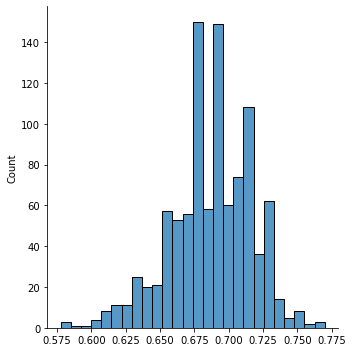

In [20]:
model_accuracies = []

for i in range(1000):
    (training_inputs, testing_inputs, training_classes,
     testing_classes) = train_test_split(X_train, y_train, train_size=0.7)
    
    clf = DecisionTreeClassifier(max_depth=2) # default max_depth=2
    clf.fit(training_inputs, training_classes)
    classifier_accuracy = clf.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
sns.displot(model_accuracies)
plt.title('', fontsize=15);

The extreme highs and lows associated with the plot shows that model is indeed overfitting. This means that the training data and does not perform well on the test set.

A method to eliminate overfitting our model is to apply cross-validation. Let us evaluate our Decision Tree model by splitting the training set into 10 folds, then train and evaluate the model 10 times. Each time we'll be picking a different evaluation subset, and using the remaining 9 subsets for training.

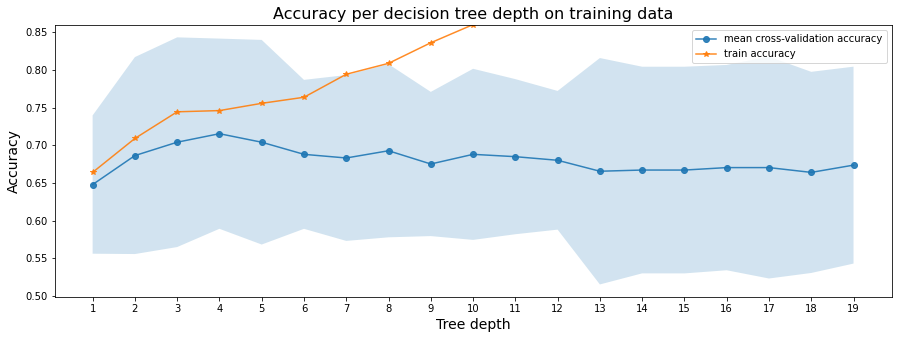

In [21]:
# source https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
from sklearn.model_selection import cross_val_score

def run_cross_validation_on_trees(X, y, tree_depths, cv=10, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 20
sm_tree_depths = range(1,20)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

From the above plot, we see that a tree depth of =>5, our model overfits the more tree depth we add. A tree depth of 4 seems like our best option, however, let's be sure that is the case, so let's be certain before we assume that 4 is our best tree depth.

In [22]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('Best Max_depth: {}\nBest mean cross-validation accuracy: {:.2f}, +/- {:.2f}%'
      .format(sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

Best Max_depth: 4
Best mean cross-validation accuracy: 71.53, +/- 6.31%


As we can see, the best max depth for our tree is 4, this gives us the best mean cross-validation with accuracy of 71.5 +/- 6.3%. We will now redo the model with a tree depth of 4, since we now know that for this particular dataset, our model has the best mean cross-validation accuracy at 72% for the training dataset.

Lets take a look at grid search where we will find the best parameters other than max_depth, in our decision tree model. 

In [25]:
# source https://www.kaggle.com/mamun18/decision-tree-practice-with-titanic-dataset-hptune
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# Create the parameter grid
param_grid = {
             "min_samples_leaf": range(50, 150, 50),
             "min_samples_split": range(50, 150, 50),
             "criterion": ['gini', 'entropy']}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree,
                          param_grid = param_grid,
                          cv = n_folds,
                          verbose = 1)

# Fit the grid Search to the data
grid_search.fit(X_train, y_train)

print("Best accuracy: ", grid_search.best_score_)
print(grid_search.best_estimator_);

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best accuracy:  0.6976
DecisionTreeClassifier(min_samples_leaf=100, min_samples_split=50)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


Notice that we know have some valuable parameters to input into our new model.

Lets apply the best max depth parameter to a new decision tree classifier model, which should give us a better confusion matrix than our initial model since we now are avoiding overfitting our data.

In [26]:
clf2 = DecisionTreeClassifier(max_depth=4, min_samples_leaf=100, min_samples_split=50).fit(X_train, y_train)
y_pred = clf2.predict(X_test)
def print_conf_mtx(y_true, y_pred, classes=None):
    if not classes:
        classes = ['neg', 'pos']
   	 
    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left   	= '{:<10s}'.replace('10',str(n))
    right  	= '{:>10s}'.replace('10',str(m))
    big_center = '{:^20s}'.replace('20',str(m*2))
    
    cm = confusion_matrix(y_test, y_pred)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))
print_conf_mtx(y_test, y_pred)

       predicted 
actual   neg  pos
neg      140   17
pos       74   36


We now have a better overall confusion matrix than we did initally. This is great new! We can be certain that our new model performs much better and more accurately than our inital model, but just to be certain, let's now take a look at our new test accuracy.

In [27]:
print('Accuracy of Model: {:.3f}'.format(clf2.score(X_test,y_test)))

Accuracy of Model: 0.659


Although our model's accuracy is slightly higher than the initial accuracy we obtained by +3 percentile, we can be certain that these parameters associated with our decision tree classifier avoids overfitting, unlike the previous models' accuracy. We've curated our model for the optimal max_depth for the titanic data set.

## Conclusions

Decision tree classifier is a very simple and easy-to-use Machine Learning model, the issue with it is overfitting so what are some key takeaways? We've learned that the optimal method to prevent overfitting is cross-validation, this is because our model after cross-validation has been applied, quantifies that the precision in our model is doing better or worse at generalization error on new unseen data. The test accuracy achieved after tuning our model was .68, and the baseline accuracy was .59, so this tells us that we do 10% better than blindly predicting. We also learned that the best max_depth for this machine learning model is 4. In retrospect, it would be great to test all parameters of our model, not just max_depth.